<a href="https://colab.research.google.com/github/lblabucsd/Zada_Schulze_24/blob/main/dc_neural_analysis_global_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

#load packages
!pip install pynrrd
!pip install scikit-posthocs

import os
import csv
import numpy as np
import pandas as pd
import math
import time
import json
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import nrrd
import scipy
from scipy import io
from scipy.fftpack import rfft, irfft, fftfreq
import scipy.stats as stats
import statsmodels
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering
import random
from random import randrange
from random import shuffle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import scikit_posthocs as sp
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("white")


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def norm(inputs):
    output = (inputs-min(inputs))/(max(inputs)-min(inputs))
    return output

def baseline_subtraction(angle, window):
    new=[]
    for ndx,i in enumerate(angle):
        if ndx<window/2 or ndx>len(angle)-window/2:
            new.append(0)
        else:
            baseline=np.median(angle[ndx-int(window/2):ndx+int(window/2)])
            new.append(i-baseline)
    return new

def resized(data,N):
    old_indices = np.linspace(0, len(data) - 1, len(data))
    new_indices = np.linspace(0, len(data) - 1, N)
    res = np.interp(new_indices, old_indices, data)
    return res

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set(font_scale=3)
sns.set_style("white")

figure_savepath = '/content/drive/MyDrive/Zada_Schulze_paper/Figures_output/Neural_activity/Global_flow/'

print('loaded')


Mounted at /content/drive/
loaded


In [ ]:
#linear model function

from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mutual_info_score, explained_variance_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle as skshuff
from copy import deepcopy


def linear_model(regressors, neurons):

    weight_set = [[] for r in regressors] #beta weights and UEVs for regressors
    pred_scores=[]

    arg_set = regressors#[norm(r) for r in regressors]
    x=np.array(arg_set).T #arrays as inputs

    for idx,i in enumerate(neurons):

        y=np.array(i) #predicting cell_fluoresence

        Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.1, random_state=5)

        regr = RidgeCV(cv=10, alphas=(0.001, 0.01, 0.1, 1.0, 10.0), gcv_mode='svd')

        regr.fit(Xtrain, ytrain)
        pred_arr = regr.predict(Xtest)
        score = regr.score(Xtest,ytest)
        ccf = regr.coef_.tolist()
        pred_scores.append(score)


        for cf,ls in zip(ccf,weight_set):
            ls.append([cf,0]) #both beta wight (cf) and unique explained variance (exp)

        if idx % 250==0:
          print("on cell # ",idx, " of ", len(neurons), 'pred score', score)
          print(ccf)
          #print(tmp)

    return pred_scores, weight_set, regressors


In [ ]:
#test linear model
import warnings
warnings.filterwarnings('ignore')

wk2_subjects = ['ml-230427-f4_starfield-3',
                'DZ-230517_wk2_f2-2_starfield',
                'DZ-230517_wk2_f1_starfield',
                'DZ-230518_wk2_f1_z-100_starfield',
                'DZ-230605-f3-100_2wk_starfield']

wk4_subjects= ['DZ-230519_wk4_f1-3_starfield',
               'DZ-230522-f2_-120_4wk_starfield',
               'DZ-230523_wk4_f2_-110_starfield',
               'DZ-230523_wk4_f1_-130_starfield']

wk6_subjects = ['DZ-230521_wk6_f4_starfield',
                'DZ-230522_wk6_f2-2_starfield',
                'DZ-230524_wk6_f1-3_starfield',
                'DZ-230526-f1-140_6wk_starfield',
                'DZ-230525-f4-170_6wk_starfield',
                'DZ-230529_wk6_f1_-130_starfield']

subjects = wk2_subjects+wk4_subjects+wk6_subjects


resample_Hz = 10 #define common Hz to resample all
ts_fraction = [0.05,0.8] #fraction of full timeseries to use (cutoff early - some z-drift in final 20% of some)

for f in subjects:
    print(f)

    path = '/content/drive/MyDrive/Zada_Schulze_paper/Imaging_data/Starfield/'+f+'/'

    #load processed imaging data
    load = np.load(path+'neuron_details_with-anatomy.npz')
    coords = load['neuron_coordinates']
    xs=[i[0] for i in coords]
    ys=[i[1] for i in coords]
    tr=load['neuron_traces']
    neuron_locations = load['neuron_anatomy']

    output_ops =np.load(path+"suite2p/plane0/ops.npy", allow_pickle=True).item()

    load=np.load(path+'movement_stats.npz', allow_pickle=True)
    tmp=load['time_sec']
    time=[i-tmp[0] for i in tmp]
    new_time_base = int(max(time)*resample_Hz)
    tail_angle=resized(load['angle'],new_time_base)
    turn_array=resized(load['any_turn_array'],new_time_base)
    stimulus=load['stim']

    s0=[float(i) for i in stimulus]
    s1=np.zeros(len(stimulus));
    s2=np.zeros(len(stimulus));
    for ndx,i in enumerate(stimulus):
      if i>0:
        s1[ndx]=1
      if i<0:
        s2[ndx]=1

    #resample all to common Hz, and crop to first X% of behavior
    S0=resized(s0,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    S1=resized(s1,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    S2=resized(s2,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    mov=resized(turn_array,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    tail=resized(tail_angle,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]

    #handle fluorescence traces here
    neuron_traces=[]
    for i in tr:
        #resize, crop, detrend, and smooth
        tmp = resized(i,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
        kernel_size = int(1.0*resample_Hz) #1.0s
        kernel = np.ones(kernel_size) / kernel_size
        tmp2 = np.convolve(tmp, kernel, mode='smooth') #smooth
        tmp2[:resample_Hz*1]=tmp2[resample_Hz*1] #correcting for edge effects
        tmp2[-resample_Hz*1:]=tmp2[-resample_Hz*1] #correcting for edge effects
        neuron_traces.append(scipy.stats.zscore(tmp2)) #append zscore

    #convolve regressors
    decay = 3.0*resample_Hz #(calcium decay - 3s x volume Hz sampling)
    #regressors are tail_angle, signed_turn_array, L_brightness, R_brightness
    tmp = pd.DataFrame(data=S0)
    s0_conv=np.array(tmp.ewm(halflife = decay).mean()).T[0]
    tmp = pd.DataFrame(data=S1)
    s1_conv=np.array(tmp.ewm(halflife = decay).mean()).T[0]
    tmp = pd.DataFrame(data=S2)
    s2_conv=np.array(tmp.ewm(halflife = decay).mean()).T[0]
    tmp = pd.DataFrame(data=mov)
    mov_conv=np.array(tmp.ewm(halflife = decay).mean()).T[0]



    if f in ['DZ-230605-f3-100_2wk_starfield','DZ-230525-f4-170_6wk_starfield']:
      print("fixing_array")
      mov_conv[100]=1.0

    #regressors = [s1_conv,s2_conv,mov_conv,tail_conv]
    regressors = [s0,mov_conv]
    pred_scores, weight_set, basis_functions = linear_model(regressors, neuron_traces)
    np.savez(path+'linear_model_outputs_ridge_V2.npz', pred_scores=pred_scores, weight_set=weight_set, regressors=regressors)

    #plotting
    for yyy in [pred_scores, weight_set]:
        print('pred', np.shape(yyy), np.shape(yyy)[0])

    plt.figure(figsize=[7,2])
    plt.subplot(131)
    plt.hist(pred_scores)
    plt.subplot(132)
    plt.scatter(xs,ys,c=pred_scores, cmap='Reds', s=4, alpha=0.2, vmin=0, vmax=1)
    plt.subplot(133)
    for ndx,i in enumerate(regressors):
      plt.plot(norm(i)-ndx)
    plt.show()


    #plotting beta weights of model
    print('beta weights')
    plt.figure(figsize=[9,5])
    for ndx,wt in enumerate(weight_set):
      plt.subplot(1,len(weight_set),ndx+1)
      plt.imshow(output_ops['meanImgE'], cmap='gray', alpha=0.6)
      plt.scatter(xs,ys,c=[np.mean(i[0]) for i in wt], cmap='bwr', s=10, alpha=0.2, vmin=-0.5, vmax=0.5)
      plt.xlim(0,800)
      plt.ylim(0,800)
    plt.show()

    #plotting UEVs of model
    print('UEVs ')
    plt.figure(figsize=[8,5])
    for ndx,wt in enumerate(weight_set):
      plt.subplot(1,len(weight_set),ndx+1)
      plt.imshow(output_ops['meanImgE'], cmap='gray', alpha=0.6)
      plt.scatter(xs,ys,c=[np.mean(i[1]) for i in wt], cmap='Reds', s=10, alpha=0.2, vmin=0, vmax=0.1)
      plt.xlim(0,800)
      plt.ylim(0,800)
    plt.show()



ml-230427-f4_starfield-3


ValueError: Found input variables with inconsistent numbers of samples: [2, 3474]

ml-230427-f4_starfield-3
DZ-230517_wk2_f2-2_starfield
DZ-230517_wk2_f1_starfield
DZ-230518_wk2_f1_z-100_starfield
DZ-230605-f3-100_2wk_starfield
DZ-230519_wk4_f1-3_starfield
DZ-230522-f2_-120_4wk_starfield
DZ-230523_wk4_f2_-110_starfield
DZ-230523_wk4_f1_-130_starfield
DZ-230521_wk6_f4_starfield
DZ-230522_wk6_f2-2_starfield
DZ-230524_wk6_f1-3_starfield
DZ-230526-f1-140_6wk_starfield
DZ-230525-f4-170_6wk_starfield
DZ-230529_wk6_f1_-130_starfield
telencephalon
SHOWING PLOTS FOR REGRESSOR  s1
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.4]: p-value = 0.575402
wk2v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.352476
wk4v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.864769
SHOWING PLOTS FOR REGRESSOR  mov
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as

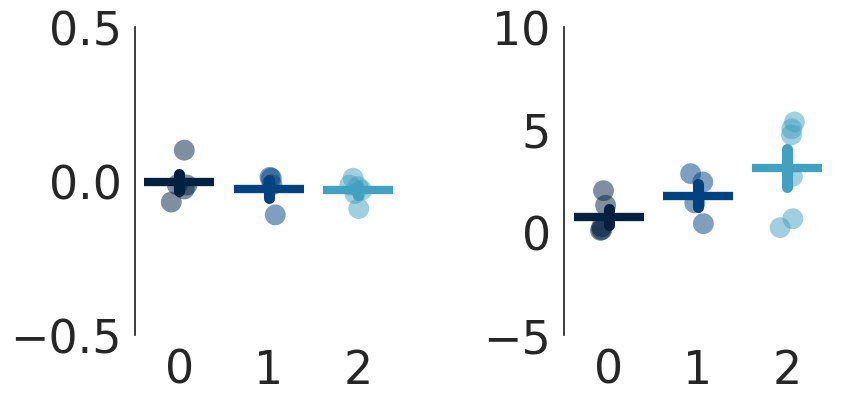

ml-230427-f4_starfield-3
DZ-230517_wk2_f2-2_starfield
DZ-230517_wk2_f1_starfield
DZ-230518_wk2_f1_z-100_starfield
DZ-230605-f3-100_2wk_starfield
DZ-230519_wk4_f1-3_starfield
DZ-230522-f2_-120_4wk_starfield
DZ-230523_wk4_f2_-110_starfield
DZ-230523_wk4_f1_-130_starfield
DZ-230521_wk6_f4_starfield
DZ-230522_wk6_f2-2_starfield
DZ-230524_wk6_f1-3_starfield
DZ-230526-f1-140_6wk_starfield
DZ-230525-f4-170_6wk_starfield
DZ-230529_wk6_f1_-130_starfield
dienencephalon
SHOWING PLOTS FOR REGRESSOR  s1
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.4]: p-value = 0.287830
wk2v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.187892
wk4v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.906115
SHOWING PLOTS FOR REGRESSOR  mov
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id a

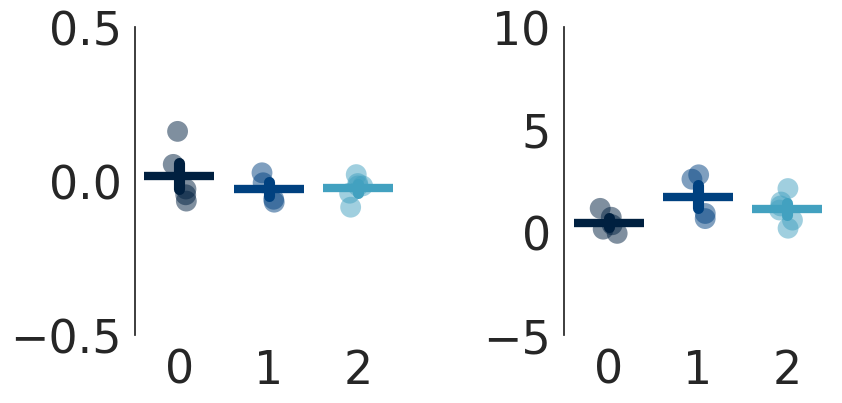

ml-230427-f4_starfield-3
DZ-230517_wk2_f2-2_starfield
DZ-230517_wk2_f1_starfield
DZ-230518_wk2_f1_z-100_starfield
DZ-230605-f3-100_2wk_starfield
DZ-230519_wk4_f1-3_starfield
DZ-230522-f2_-120_4wk_starfield
DZ-230523_wk4_f2_-110_starfield
DZ-230523_wk4_f1_-130_starfield
DZ-230521_wk6_f4_starfield
DZ-230522_wk6_f2-2_starfield
DZ-230524_wk6_f1-3_starfield
DZ-230526-f1-140_6wk_starfield
DZ-230525-f4-170_6wk_starfield
DZ-230529_wk6_f1_-130_starfield
mesencephalon
SHOWING PLOTS FOR REGRESSOR  s1
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.4]: p-value = 0.976502
wk2v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.370563
wk4v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.602187
SHOWING PLOTS FOR REGRESSOR  mov
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as

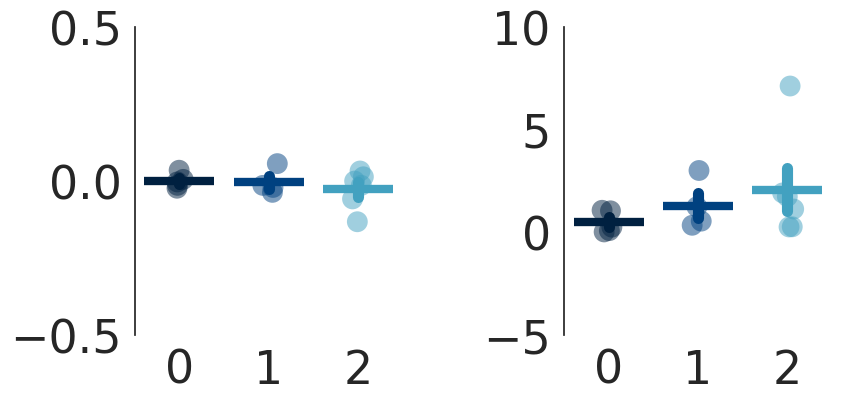

ml-230427-f4_starfield-3
DZ-230517_wk2_f2-2_starfield
DZ-230517_wk2_f1_starfield
DZ-230518_wk2_f1_z-100_starfield
DZ-230605-f3-100_2wk_starfield
DZ-230519_wk4_f1-3_starfield
DZ-230522-f2_-120_4wk_starfield
DZ-230523_wk4_f2_-110_starfield
DZ-230523_wk4_f1_-130_starfield
DZ-230521_wk6_f4_starfield
DZ-230522_wk6_f2-2_starfield
DZ-230524_wk6_f1-3_starfield
DZ-230526-f1-140_6wk_starfield
DZ-230525-f4-170_6wk_starfield
DZ-230529_wk6_f1_-130_starfield
rhombencephalon
SHOWING PLOTS FOR REGRESSOR  s1
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.4]: p-value = 0.472612
wk2v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.264248
wk4v6 week: statistics for comparison: linear mixed-effects model, with fish id as random variable
group[T.6]: p-value = 0.758880
SHOWING PLOTS FOR REGRESSOR  mov
wk2v4 week: statistics for comparison: linear mixed-effects model, with fish id 

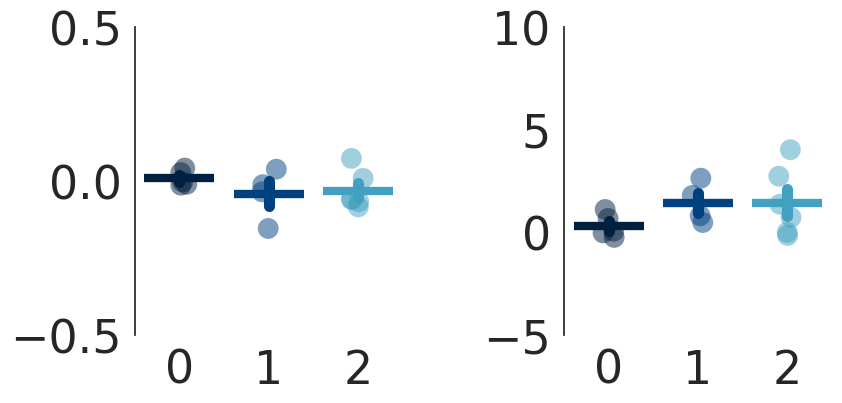

In [ ]:
#plotting data for neurons (pooled across animals)

wk2_subjects = ['ml-230427-f4_starfield-3',
                'DZ-230517_wk2_f2-2_starfield',
                'DZ-230517_wk2_f1_starfield',
                'DZ-230518_wk2_f1_z-100_starfield',
                'DZ-230605-f3-100_2wk_starfield']

wk4_subjects= ['DZ-230519_wk4_f1-3_starfield',
               'DZ-230522-f2_-120_4wk_starfield',
               'DZ-230523_wk4_f2_-110_starfield',
               'DZ-230523_wk4_f1_-130_starfield']

wk6_subjects = ['DZ-230521_wk6_f4_starfield',
                'DZ-230522_wk6_f2-2_starfield',
                'DZ-230524_wk6_f1-3_starfield',
                'DZ-230526-f1-140_6wk_starfield',
                'DZ-230525-f4-170_6wk_starfield',
                'DZ-230529_wk6_f1_-130_starfield']

subjects = wk2_subjects+wk4_subjects+wk6_subjects

brain_regions = ['dorsal_forebrain', 'ventral_forebrain', 'habenula','thalamus',\
                 'left_tectum_neuropil', 'left_tectum_cell-layer',\
                 'right_tectum_neuropil', 'right_tectum_cell-layer',\
                 'cerebellum', 'hindbrain']

brain_region_groupings = [['telencephalon', 'dorsal_forebrain', 'ventral_forebrain'],\
                          ['dienencephalon', 'habenula','thalamus'],\
                          ['mesencephalon', 'left_tectum_neuropil', 'left_tectum_cell-layer','right_tectum_neuropil', 'right_tectum_cell-layer'],\
                          ['rhombencephalon', 'cerebellum', 'hindbrain']]



for region in brain_region_groupings:

    b_wk2={}; b_wk4={}; b_wk6={}; #betas
    for i in ['f_id','f_grp','s1','mov','s1_byfish','mov_byfish']: #each stimulus type
      b_wk2[i]=[]; b_wk4[i]=[]; b_wk6[i]=[];

    for f in subjects:

      print(f)
      path = '/content/drive/MyDrive/Zada_Schulze_paper/Imaging_data/Starfield/'+f+'/'

      load = np.load(path+'neuron_details_with-anatomy.npz', allow_pickle=True)
      neuron_locations = load['neuron_anatomy']

      #load=np.load(path+'linear_model_outputs_ridge.npz', allow_pickle=True)
      #basis_functions=load['basis_functions']
      #pred_scores=load['pred_scores']
      #weight_set=load['weight_set']

      load=np.load(path+'linear_model_outputs_ridge_V2.npz', allow_pickle=True)
      pred_scores=load['pred_scores']
      weight_set=load['weight_set']

      if f in wk2_subjects:
        for index,(weights,regs,regs_byfish) in enumerate(zip(weight_set, ['s1','mov'],['s1_byfish','mov_byfish'])):
          b_wk2[regs_byfish].append(np.mean([np.mean(i[0]) for i,loc in zip(weights,neuron_locations) if loc in region]))
          for i,j,loc in zip(weights,pred_scores,neuron_locations):
            if loc in region:
              b_wk2[regs].append(np.mean(i[0]))
              if index==0:
                b_wk2['f_id'].append(f)#ndx)
                b_wk2['f_grp'].append('2')
      if f in wk4_subjects:
        for index,(weights,regs,regs_byfish) in enumerate(zip(weight_set, ['s1','mov'],['s1_byfish','mov_byfish'])):
          b_wk4[regs_byfish].append(np.mean([np.mean(i[0]) for i,loc in zip(weights,neuron_locations) if loc in region]))
          for i,j,loc in zip(weights,pred_scores,neuron_locations):
            if loc in region:
              b_wk4[regs].append(np.mean(i[0]))
              if index==0:
                b_wk4['f_id'].append(f)#ndx)
                b_wk4['f_grp'].append('4')
      if f in wk6_subjects:
        for index,(weights,regs,regs_byfish) in enumerate(zip(weight_set, ['s1','mov'],['s1_byfish','mov_byfish'])):
          b_wk6[regs_byfish].append(np.mean([np.mean(i[0]) for i,loc in zip(weights,neuron_locations) if loc in region]))
          for i,j,loc in zip(weights,pred_scores,neuron_locations):
            if loc in region:
              b_wk6[regs].append(np.mean(i[0]))
              if index==0:
                b_wk6['f_id'].append(f)#ndx)
                b_wk6['f_grp'].append('6')

    plt.figure(figsize=[9,4])
    plt.tight_layout(pad=10.0)
    #plt.ylabel('mean beta')
    print(region[0])
    for ndx,(regs,regs_byfish) in enumerate(zip(['s1','mov'],['s1_byfish','mov_byfish'])):

      print("SHOWING PLOTS FOR REGRESSOR ", regs)

      #betas from model
      plt.subplot(1,2,ndx+1)
      #plt.title(regs+" betas")
      summary_data = [b_wk2[regs],b_wk4[regs],b_wk6[regs]]
      summary_data_byfish = [b_wk2[regs_byfish],b_wk4[regs_byfish],b_wk6[regs_byfish]]
      summary_fids = [b_wk2['f_id'],b_wk4['f_id'],b_wk6['f_id']]
      summary_grps = [b_wk2['f_grp'],b_wk4['f_grp'],b_wk6['f_grp']]

      sns.pointplot(data=summary_data_byfish, estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette='ocean', linestyle='none')
      sns.stripplot(data=summary_data_byfish, s=15, palette='ocean', jitter=True, alpha=0.5)

      if regs=='mov':
        plt.ylim(-5,10)
      else:
        plt.ylim(-0.5,0.5)

      sns.despine(top=True, right=True, bottom=True)

      for ndxa,groupA,groupB in zip(['wk2v4','wk2v6','wk4v6'],[b_wk2,b_wk2,b_wk4],[b_wk4,b_wk6,b_wk6]):
        print(ndxa,'week: statistics for comparison: linear mixed-effects model, with fish id as random variable')

        df = pd.DataFrame({
                  'cell_values': np.concatenate([groupA[regs],groupB[regs]]),
                  'group': np.concatenate([groupA['f_grp'],groupB['f_grp']]),
                  'fish_ID': np.concatenate([groupA['f_id'],groupB['f_id']]),
                  })

        # Convert 'group' to categorical if it's not already
        df['group'] = df['group'].astype('category')

        # Fit the linear mixed-effects model
        model = smf.mixedlm("cell_values ~ group", df, groups=df['fish_ID'])
        result = model.fit()

        # Print the summary of the model
        #print(result.summary())
        p_values = result.pvalues
        # Print p-values with increased precision
        for index,(param, p_value) in enumerate(p_values.items()):
          if index==1:
            print(f"{param}: p-value = {p_value:.6f}")

    plt.subplots_adjust(hspace=0.5, wspace=0.6)
    plt.savefig(figure_savepath +"model_betas_"+region[0]+".pdf", transparent=True, bbox_inches='tight', pad_inches=0.2)
    plt.show()



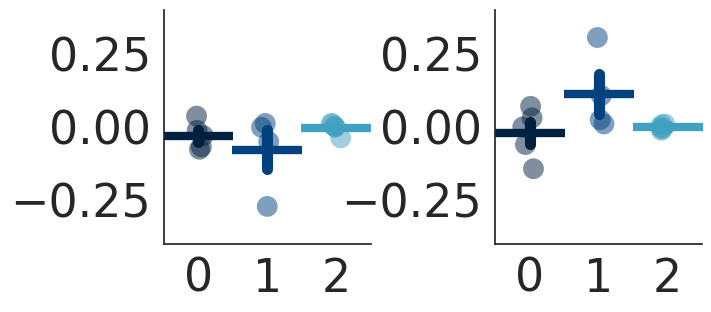

In [ ]:
#here, get behavioral response to different stimuli

wk2_subjects = ['ml-230427-f4_starfield-3',
                'DZ-230517_wk2_f2-2_starfield',
                'DZ-230517_wk2_f1_starfield',
                'DZ-230518_wk2_f1_z-100_starfield',
                'DZ-230605-f3-100_2wk_starfield']

wk4_subjects= ['DZ-230519_wk4_f1-3_starfield',
               'DZ-230522-f2_-120_4wk_starfield',
               'DZ-230523_wk4_f2_-110_starfield',
               'DZ-230523_wk4_f1_-130_starfield']

wk6_subjects = ['DZ-230521_wk6_f4_starfield',
                'DZ-230522_wk6_f2-2_starfield',
                'DZ-230524_wk6_f1-3_starfield',
                'DZ-230526-f1-140_6wk_starfield',
                'DZ-230525-f4-170_6wk_starfield',
                'DZ-230529_wk6_f1_-130_starfield']

subjects = wk2_subjects+wk4_subjects+wk6_subjects


w2S1=[]; w2S2=[];
w4S1=[]; w4S2=[];
w6S1=[]; w6S2=[];
w2S1_psth=[]; w2S2_psth=[];
w4S1_psth=[]; w4S2_psth=[];
w6S1_psth=[]; w6S2_psth=[];


for f in subjects:

    path ='/content/drive/MyDrive/Zada_Schulze_paper/Imaging_data/Starfield/'+f+'/'

    load=np.load(path+'movement_stats.npz', allow_pickle=True)
    tmp=load['time_sec']
    time=[i-tmp[0] for i in tmp]
    tail_angle=load['angle']
    turn_array=load['any_turn_array']
    all_mov=load['all_array']
    stimulus=load['stim']

    S1=np.zeros(len(stimulus));
    S2=np.zeros(len(stimulus));
    for ndx,i in enumerate(stimulus):
      if i>0:
        S1[ndx]=1
      if i<0:
        S2[ndx]=1

    post_stim_dur= 12*120   #post-stimulus duration (s)
    pre_stim_dur= 4*120

    S1_ON = [ndx for ndx,i in enumerate(S1) if i>0 and S1[ndx-1]==0 and pre_stim_dur < ndx < len(S1)-post_stim_dur]
    S2_ON = [ndx for ndx,i in enumerate(S2) if i>0 and S2[ndx-1]==0 and pre_stim_dur < ndx < len(S2)-post_stim_dur]

    if f in wk2_subjects:
      w2S1.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx]) for ndx in S1_ON], axis=0))
      w2S2.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx]) for ndx in S2_ON], axis=0))
      w2S1_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S1_ON], axis=0))
      w2S2_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S2_ON], axis=0))
    if f in wk4_subjects:
      w4S1.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx]) for ndx in S1_ON], axis=0))
      w4S2.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx]) for ndx in S2_ON], axis=0))
      w4S1_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S1_ON], axis=0))
      w4S2_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S2_ON], axis=0))
    if f in wk6_subjects:
      w6S1.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx]) for ndx in S1_ON], axis=0))
      w6S2.append(np.mean([np.mean(all_mov[ndx:ndx+post_stim_dur])-np.mean(all_mov[ndx-pre_stim_dur:ndx])for ndx in S2_ON], axis=0))
      w6S1_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S1_ON], axis=0))
      w6S2_psth.append(np.mean([turn_array[ndx-pre_stim_dur:ndx+post_stim_dur] for ndx in S2_ON], axis=0))



plt.figure(figsize=[8,4])
plt.subplot(121)
sns.pointplot(data = [w2S1,w4S1,w6S1], estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette='ocean', linestyle='none')
sns.stripplot(data = [w2S1,w4S1,w6S1], s=15, palette='ocean', jitter=True, alpha=0.5)

#plt.title('Left')
plt.ylim(-0.4,0.4)
plt.subplot(122)

sns.pointplot(data = [w2S2,w4S2,w6S2], estimator='mean', errorbar='se', markers='_', markersize=50, linewidth=8, palette='ocean', linestyle='none')
sns.stripplot(data = [w2S2,w4S2,w6S2], s=15, palette='ocean', jitter=True, alpha=0.5)
#plt.title('Right')
plt.ylim(-0.4,0.4)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(hspace=0.5, wspace=0.6)
#plt.savefig(figure_savepath +"behavioral_responses.pdf", transparent=True)
plt.show()


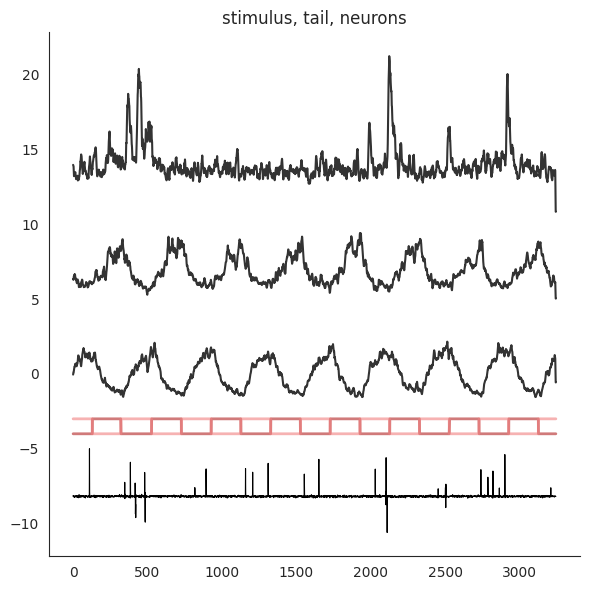

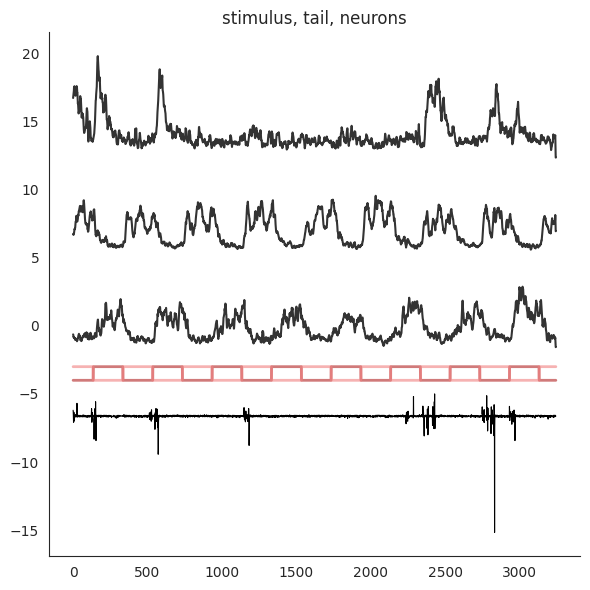

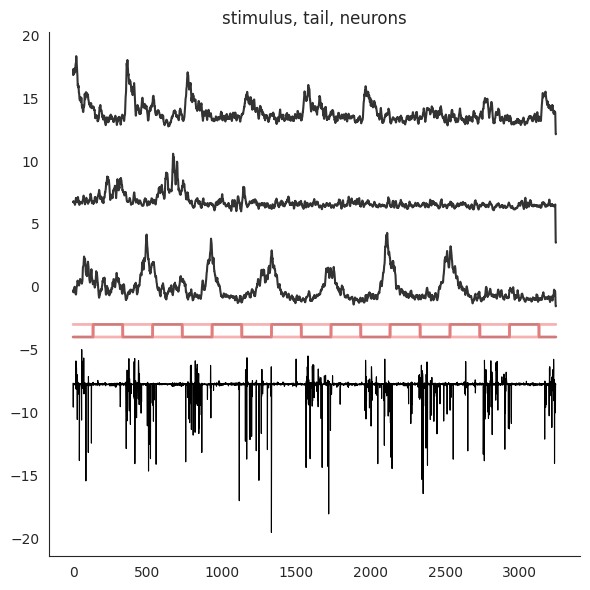

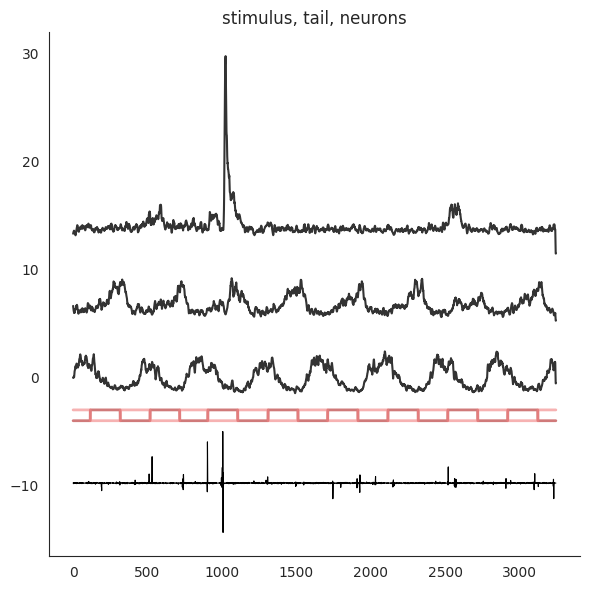

In [ ]:
wk4_subjects= ['DZ-230519_wk4_f1-3_starfield','DZ-230522-f2_-120_4wk_starfield','DZ-230523_wk4_f2_-110_starfield','DZ-230523_wk4_f1_-130_starfield']

wk6_subjects = ['DZ-230521_wk6_f4_starfield','DZ-230522_wk6_f2-2_starfield','DZ-230524_wk6_f1-3_starfield', 'DZ-230526-f1-140_6wk_starfield','DZ-230525-f4-170_6wk_starfield','DZ-230529_wk6_f1_-130_starfield']

subjects = wk4_subjects

resample_Hz = 10 #define common Hz to resample all
ts_fraction = [0.05,1.0] #fraction of full timeseries to use

for f in subjects:
    path = '/content/drive/MyDrive/Zada_Schulze_paper/Imaging_data/Starfield/'+f+'/'

    #load processed imaging data
    load = np.load(path+'neuron_details_with-anatomy.npz', allow_pickle=True)
    tr=load['neuron_traces']


    load=np.load(path+'movement_stats.npz', allow_pickle=True)
    tmp=load['time_sec']
    time=[i-tmp[0] for i in tmp]
    new_time_base = int(max(time)*resample_Hz)
    tail_angle=resized(load['angle'],new_time_base)
    stimulus=load['stim']

    load=np.load(path+'linear_model_outputs_ridge.npz', allow_pickle=True)
    pred_scores=load['pred_scores']
    weight_set=load['weight_set']

    s0=[float(i) for i in stimulus]
    s1=np.zeros(len(stimulus));
    s2=np.zeros(len(stimulus));
    for ndx,i in enumerate(stimulus):
      if i>0:
        s1[ndx]=1
      if i<0:
        s2[ndx]=1

    #resample all to common Hz, and crop to first X% of behavior
    S0=resized(s0,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    S1=resized(s1,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    S2=resized(s2,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
    tail_angle2 = tail_angle[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]

    #handle fluorescence traces here
    neuron_traces__=[]
    for i in tr:
      tmp = resized(i,new_time_base)[int(new_time_base*ts_fraction[0]):int(new_time_base*ts_fraction[1])]
      kernel_size = int(1.0*resample_Hz) #1s
      kernel = np.ones(kernel_size) / kernel_size
      tmp3 = np.convolve(tmp, kernel, mode='same') #smooth
      tmp3[0]=tmp3[1]; tmp3[-1]=tmp3[-2]
      neuron_traces__.append(scipy.stats.zscore(tmp3)) #append zscore

    plt.figure(figsize=[6,6])
    plt.tight_layout(pad=3.0)
    st=1200;ed=4800;
    examplecount=0
    for ndx in range(2):
      for w,tr in zip(weight_set[ndx],neuron_traces__):
        if w[0]==max([w[0] for w in weight_set[ndx]]):
          plt.plot(tr[st:ed] + examplecount*7, color='k', linewidth=1.5, alpha=0.8)
          examplecount+=1
        if ndx<1 and w[0]==min([w[0] for w in weight_set[ndx]]):
          plt.plot(tr[st:ed] + examplecount*7, color='k', linewidth=1.5, alpha=0.8)
          examplecount+=1

    plt.plot(S1[st:ed]-4, color='firebrick', linewidth=2.0, alpha=0.6)
    plt.plot(S2[st:ed]-4, color='lightcoral', linewidth=2.0, alpha=0.6)
    #plt.plot(np.zeros(len(S4[st:ed]))-4, color='k', linewidth=3.0)
    plt.plot((tail_angle2[st:ed]/10)-max(tail_angle2[st:ed]/10)-5, color='k', linewidth=0.8)
    plt.title('stimulus, tail, neurons')
    plt.tight_layout()
    plt.savefig(figure_savepath +"Example_globalmotion_tuned_neurons"+f+".pdf", transparent=True)
    sns.despine()
    plt.show()